# Pocket-level evaluation for P2Rank
Replicate the approach from `./pocket-level-evaluation.ipynb` on the CryptoBench test set, however, on the results from P2Rank.

In [ ]:
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import cryptoshow_utils

P2RANK_PREDICTIONS_PATH = '/home/vit/Projects/cryptobench/data/H-prediction-evaluation/ahoj-v2/p2rank/p2rank-predictions/predict_single-pair-test_apo'

def read_predicted_pockets_p2rank(protein_ids) -> dict[str, list[set[int]]]:
    '''Reads predicted pockets from P2Rank output files.
    Args:
        protein_ids: List of protein IDs in the format PDB-ID_CHAIN-ID (e.g. 1abc_A)
    Returns:
        predicted_pockets: A dictionary mapping protein IDs to a list of predicted pockets,
        where each pocket is represented as a set of residue indices (integers).
        sequences: A dictionary mapping protein IDs to their corresponding sequences.
    '''
    predicted_pockets = {}
    sequences = {}

    for protein_id in protein_ids:
        pdb_id, chain_id = protein_id.split('_')
        filename = f'{P2RANK_PREDICTIONS_PATH}/{pdb_id.lower()}.cif_predictions.csv'
        with open(filename, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            next(reader)  # skip header
            data = list(reader)
            row_count = len(data)

            pockets = []

            if row_count == 0:
                predicted_pockets[protein_id] = pockets
                _, sequence = cryptoshow_utils.map_auth_to_mmcif_numbering(pdb_id, chain_id, [])
                sequences[protein_id] = sequence
                continue

            for row in data:
                residue_indices = row[9].strip().split(' ')

                # check that they have correct chain id and add collect them
                pocket_residues = set()
                for res_idx in residue_indices:
                    this_chain_id, res_num = res_idx.split('_')
                    if this_chain_id != chain_id:
                        continue
                    pocket_residues.add(res_num)
                
                pocket_residues, sequence = cryptoshow_utils.map_auth_to_mmcif_numbering(pdb_id, chain_id, pocket_residues)
                pockets.append(pocket_residues)
                sequences[protein_id] = sequence
            predicted_pockets[protein_id] = pockets

    return predicted_pockets, sequences

## Test on CRYPTIC pockets
Take only the CRYPTIC pockets and check P2Rank performance.

In [2]:
# load CB test set and P2Rank predictions
from eval_utils import read_test_binding_residues
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['CRYPTIC'])
predicted_pockets, sequences = read_predicted_pockets_p2rank(cryptic_binding_residues.keys())

# check that sequences match (the ground-truth sequences taken from the src/A-cluster-ligysis-data/main.ipynb and the sequences extracted from the mmCIF files when reading the P2Rank predictions)
for key in cryptic_binding_residues.keys():
    assert ground_truth_sequences[key] == sequences[key], f"Sequences do not match for {key}!"

In [3]:
# to combine p2rank-predicted and model-predicted pockets, save the predicted pockets to a file
import pickle

out_path = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/predicted_pockets_p2rank.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(predicted_pockets, f, protocol=pickle.HIGHEST_PROTOCOL)

predicted_pockets = {key:[np.array([int(ii[1:]) for ii in i]) for i in predicted_pockets] for key, predicted_pockets in predicted_pockets.items()}

## Compute metrics and plot
Compute DCC, coverage, dice coefficient and plot histograms.

In [5]:
import eval_utils
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_pockets, {}, COORDINATES_DIR)


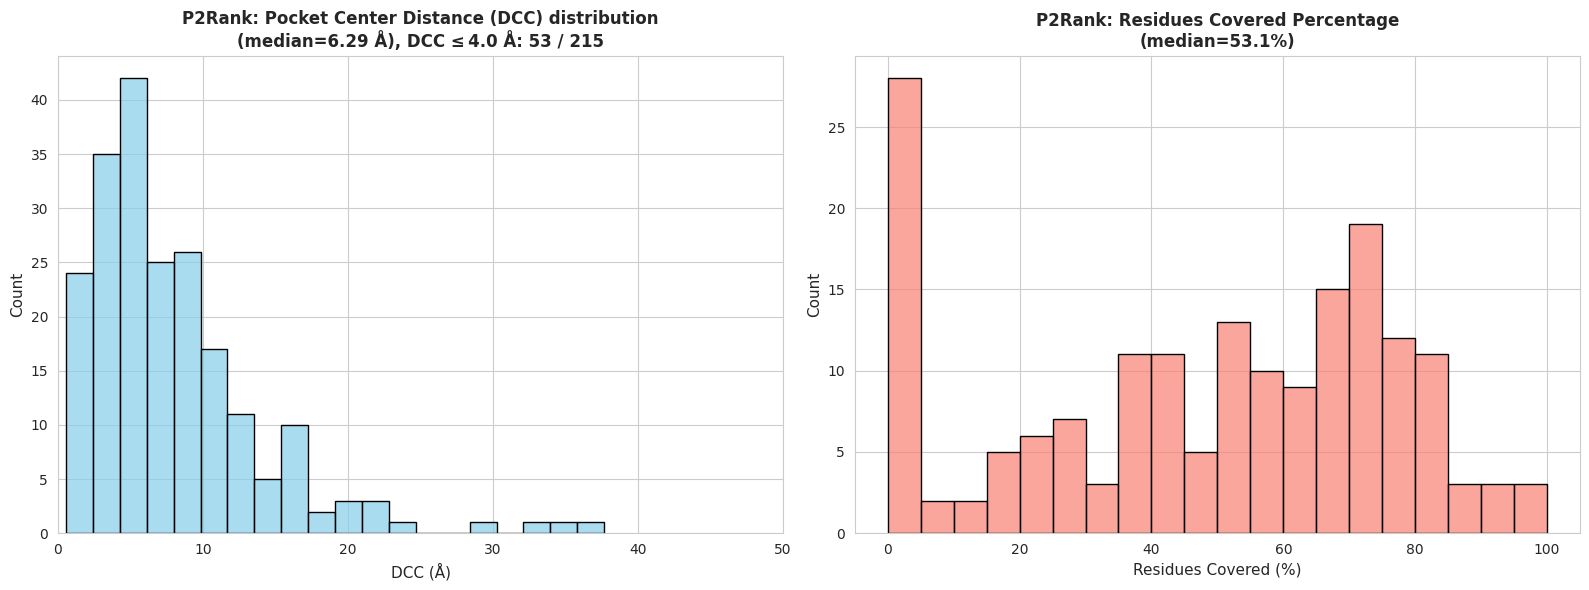

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


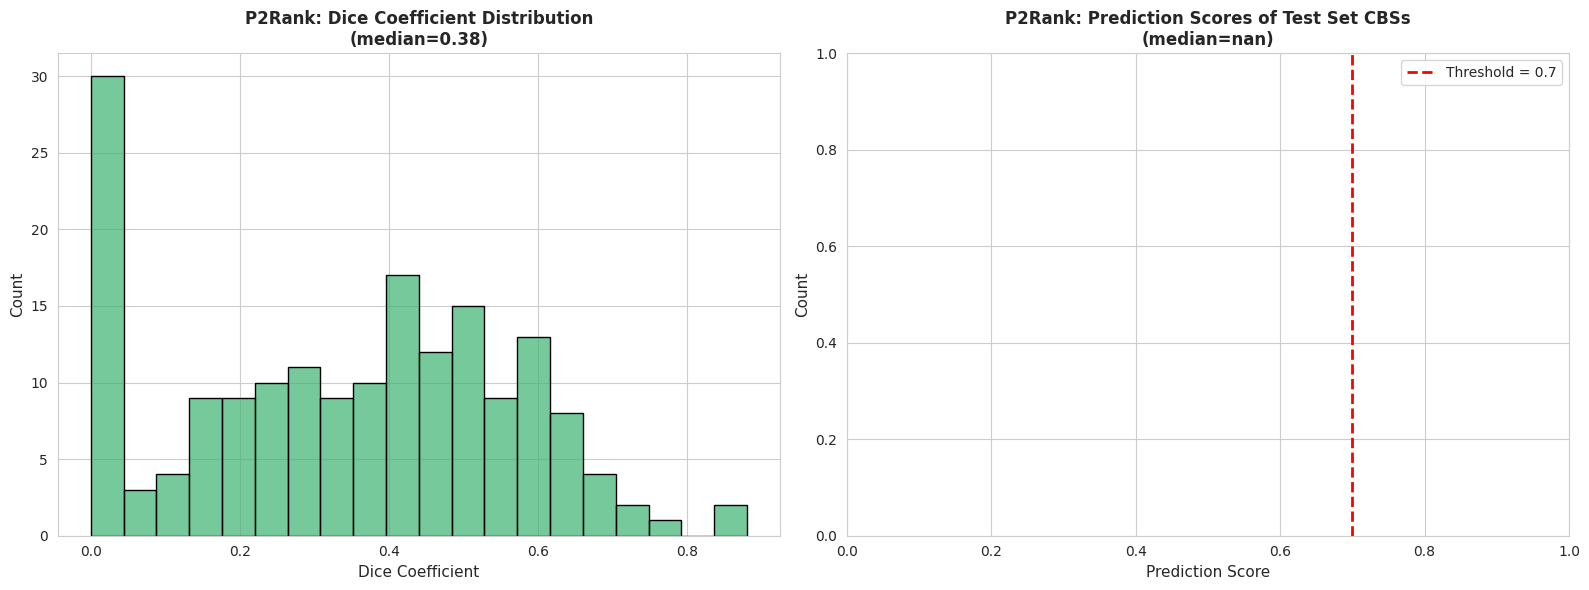

In [6]:
DCC_THRESHOLD = 4.0  # in Angstroms
MODEL = 'P2Rank'

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

## Test on NON-CRYPTIC pockets
Take only the NON-CRYPTIC pockets and check P2Rank performance.

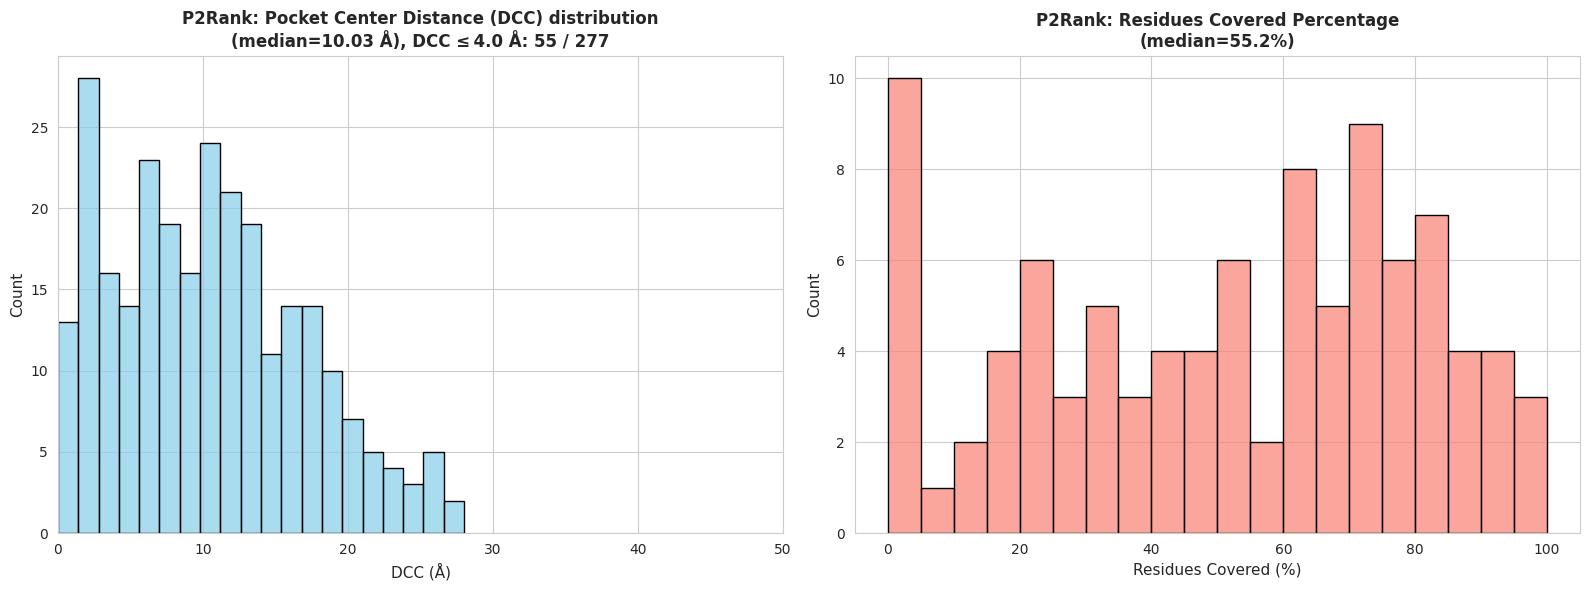

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


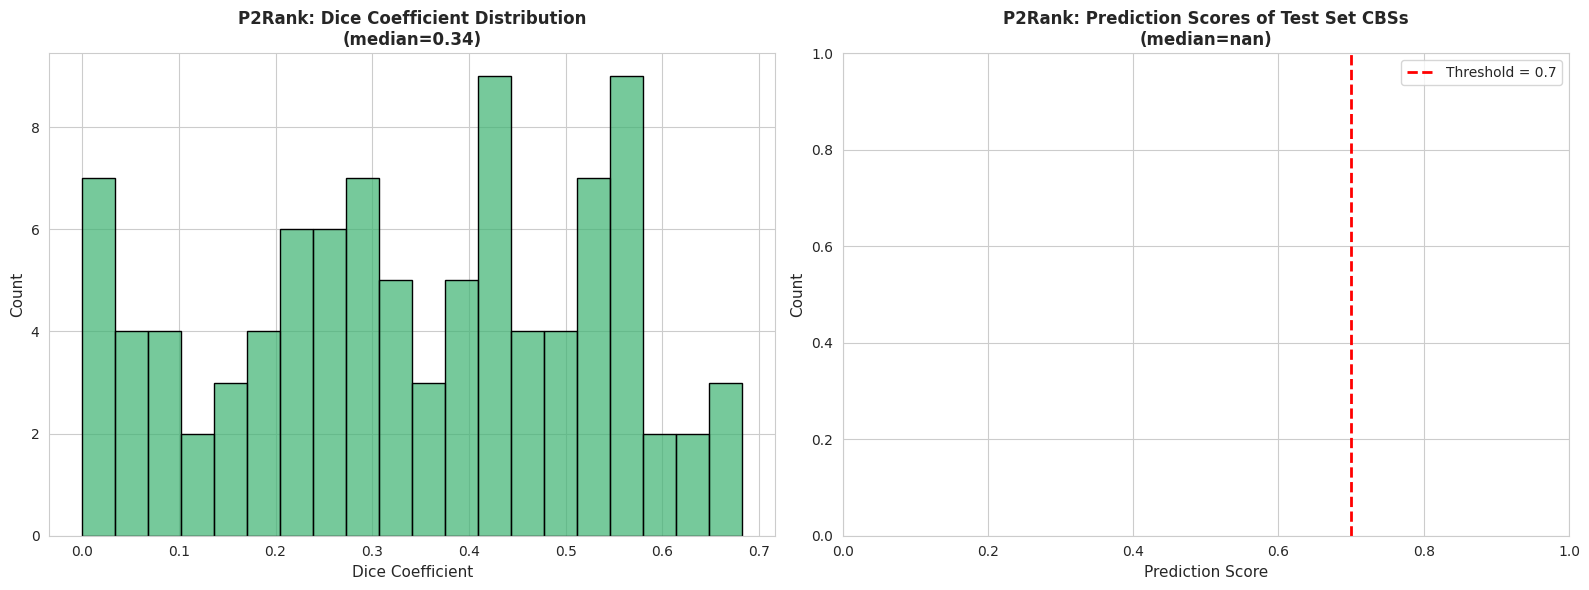

In [7]:
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['NON_CRYPTIC'])
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_pockets, {}, COORDINATES_DIR)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

## Test on NON-CRYPTIC AND CRYPTIC pockets
Take both CRYPTIC and NON-CRYPTIC pockets and check P2Rank performance.

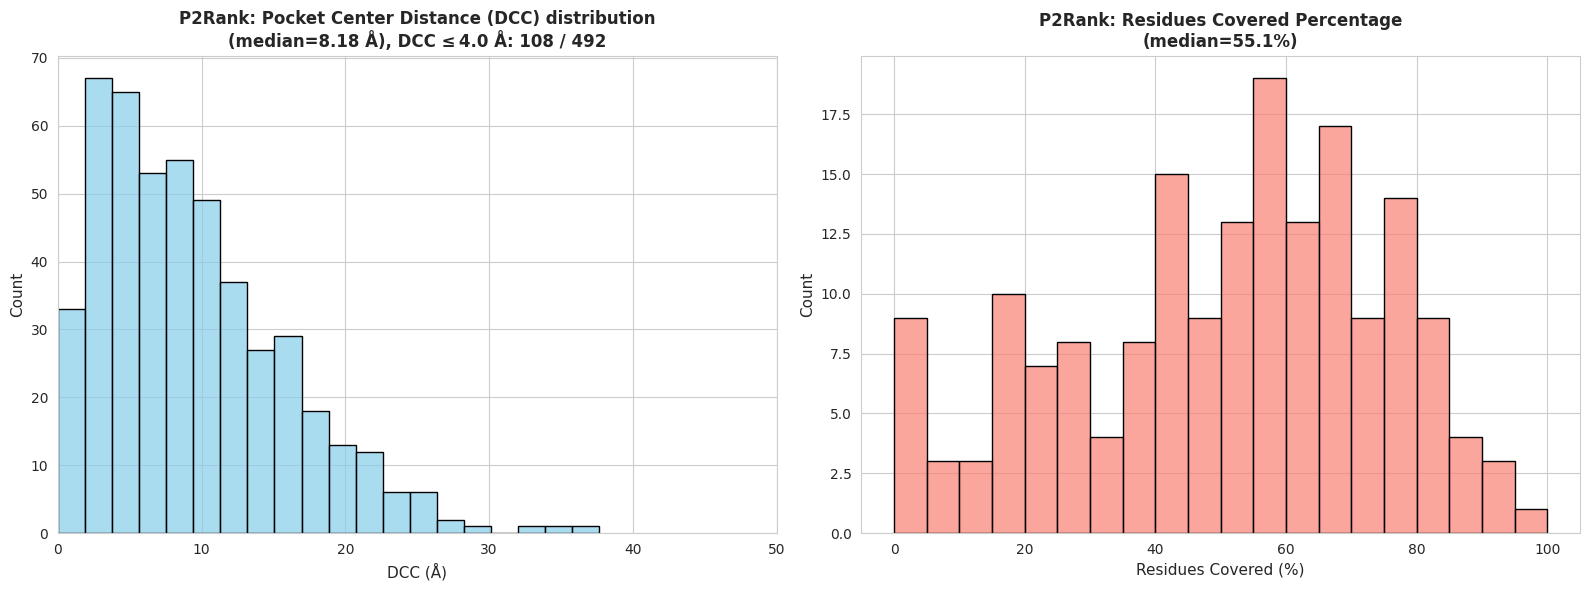

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


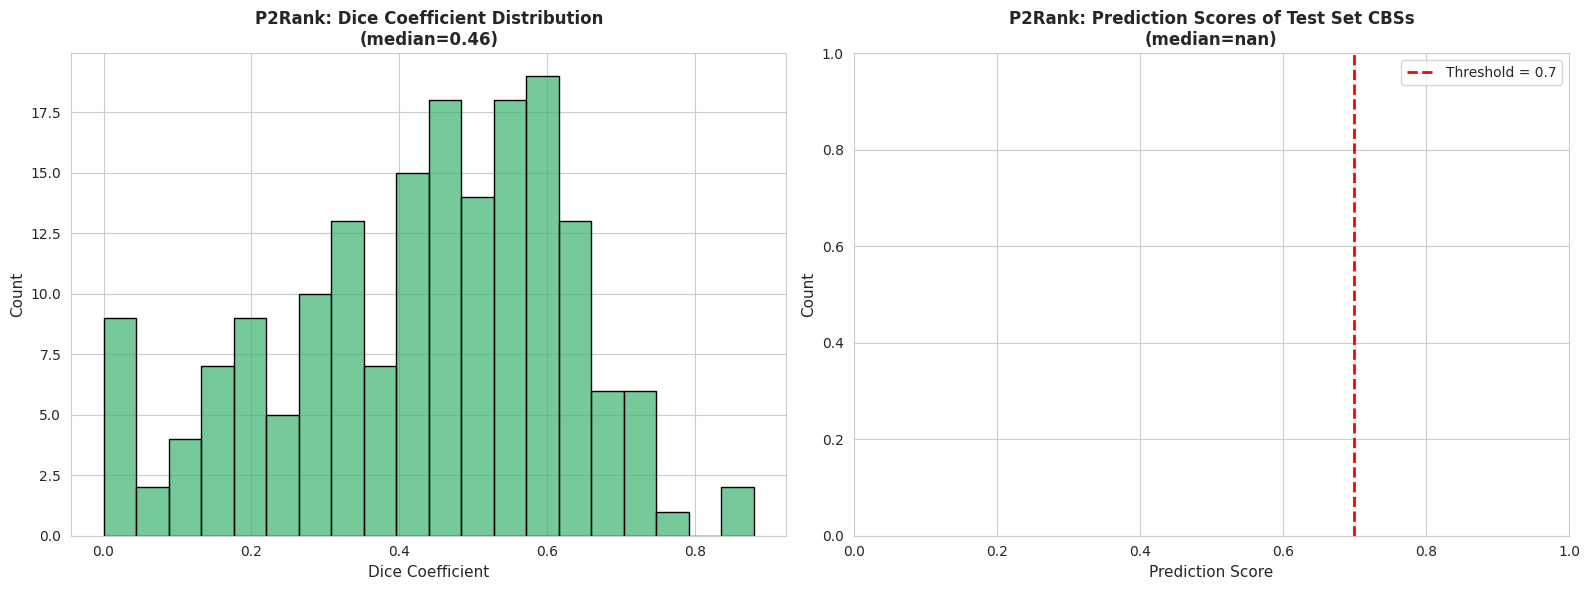

In [9]:
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['NON_CRYPTIC', 'CRYPTIC'])
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_pockets, {}, COORDINATES_DIR)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)